In [85]:
import datajoint as dj
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import pandas as pd

import sys
sys.path.append('/Users/jessbreda/Desktop/github/jbreda_animal_training/notebooks/_active_experiments/FixationGrower')
import config_alpha_experiment as alpha_config



import behav_viz.ingest as ingest
import behav_viz.visualize as viz
import behav_viz.utils as utils
from behav_viz.utils import plot_utils as pu
FIGURES_PATH = utils.dir_utils.get_figures_path("rats", "alpha")

# settings
%load_ext autoreload
%autoreload 2
sns.set_context("talk")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 0. Load In & Clean

need to drop
R044 for all dates after 2024-08-20

In [102]:
date_min = alpha_config.ALPHA_START_DATES["alpha_1"]
date_max = "2024-09-01"  # no longer analyzing new data after this date
tdf = ingest.create_trials_df.create_trials_df_from_dj(
    alpha_config.ALPHA_ANIMALS, date_min, date_max=date_max
)

animal_id R040
Fetched 40 dates from Sessions table from 2024-07-20 to 2024-08-29 for R040

animal_id R041
Fetched 41 dates from Sessions table from 2024-07-20 to 2024-08-29 for R041

animal_id R042
Fetched 41 dates from Sessions table from 2024-07-20 to 2024-08-29 for R042

animal_id R043
Fetched 42 dates from Sessions table from 2024-07-20 to 2024-08-29 for R043

animal_id R044
Fetched 33 dates from Sessions table from 2024-07-20 to 2024-08-29 for R044

animal_id R045
Fetched 40 dates from Sessions table from 2024-07-20 to 2024-08-29 for R045

animal_id R046
Fetched 41 dates from Sessions table from 2024-07-20 to 2024-08-29 for R046

animal_id R047
Fetched 36 dates from Sessions table from 2024-07-20 to 2024-08-29 for R047

animal_id R048
Fetched 32 dates from Sessions table from 2024-07-27 to 2024-08-29 for R048

animal_id R049
Fetched 31 dates from Sessions table from 2024-07-29 to 2024-08-29 for R049

animal_id R050
Fetched 34 dates from Sessions table from 2024-07-27 to 2024-08-2

In [108]:
tdf = ingest.drop_dates(tdf, alpha_config.ALPHA_DATE_DROPS)

r044_max_date = pd.Timestamp(
    "2024-08-20"
).date()  # this animal had a rig break and needs to be dropped
ex = tdf.query("not (animal_id == 'R044' and date > @r044_max_date)")

dropping R046 2024-08-12 length: 184052
length: 184052
dropping R052 2024-08-14 length: 184052
length: 184052
dropping R051 2024-08-22 length: 184052
length: 184052


In [109]:
ex.query("animal_id == 'R044'").date.max()

datetime.date(2024, 8, 20)

## 0.1 Identifying animals

In [110]:
aid_have_reached_target = (
    tdf.query("has_reached_target_fixation == 1").animal_id.unique().tolist()
)
aid_dropped_out = ["R044"]
aid_still_growing = list(
    set(alpha_config.ALPHA_ANIMALS)
    - set(aid_have_reached_target)
    - set(aid_dropped_out)
)

# 1. Robustness

# 2. Speed

# 3. Quality

## 3.1 Failed Fixation Rate by Stage

In [131]:
failed_fix_df = viz.FixationGrower.df_preperation.compute_failed_fixation_rate_df(
    tdf.query("stage >=5")
)

type_map = {"violation": "Penalty On", "by_poke": "Penalty Off"}

failed_fix_df.query("type != 'by_trial'", inplace=True)
failed_fix_df["type"] = failed_fix_df.type.map(type_map)

failed_fix_df.head()

/Users/jessbreda/Desktop/github/jbreda_animal_training/src/behav_viz/visualize/FixationGrower/df_preperation.py:159: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ).apply(compute_failed_fixation_rate)


,animal_id,stage,fix_experiment,date,type,failure_rate
0,R040,5.0,V1,2024-08-01,Penalty On,0.261364
1,R040,6.0,V1,2024-08-02,Penalty On,0.157459
2,R040,7.0,V1,2024-08-03,Penalty On,0.154394
3,R040,7.0,V1,2024-08-04,Penalty On,0.217865
4,R040,7.0,V1,2024-08-05,Penalty On,0.197889


In [132]:
cpoke_learning_failed_fix = failed_fix_df.query("stage <=8").copy()
probe_failed_fix = failed_fix_df.query("stage >= 9 and stage < 11").copy()
aid_still_growing_failed_fix = failed_fix_df.query(
    "animal_id in @aid_still_growing"
).copy()

###  3.1.1 Fixation Growth Stages

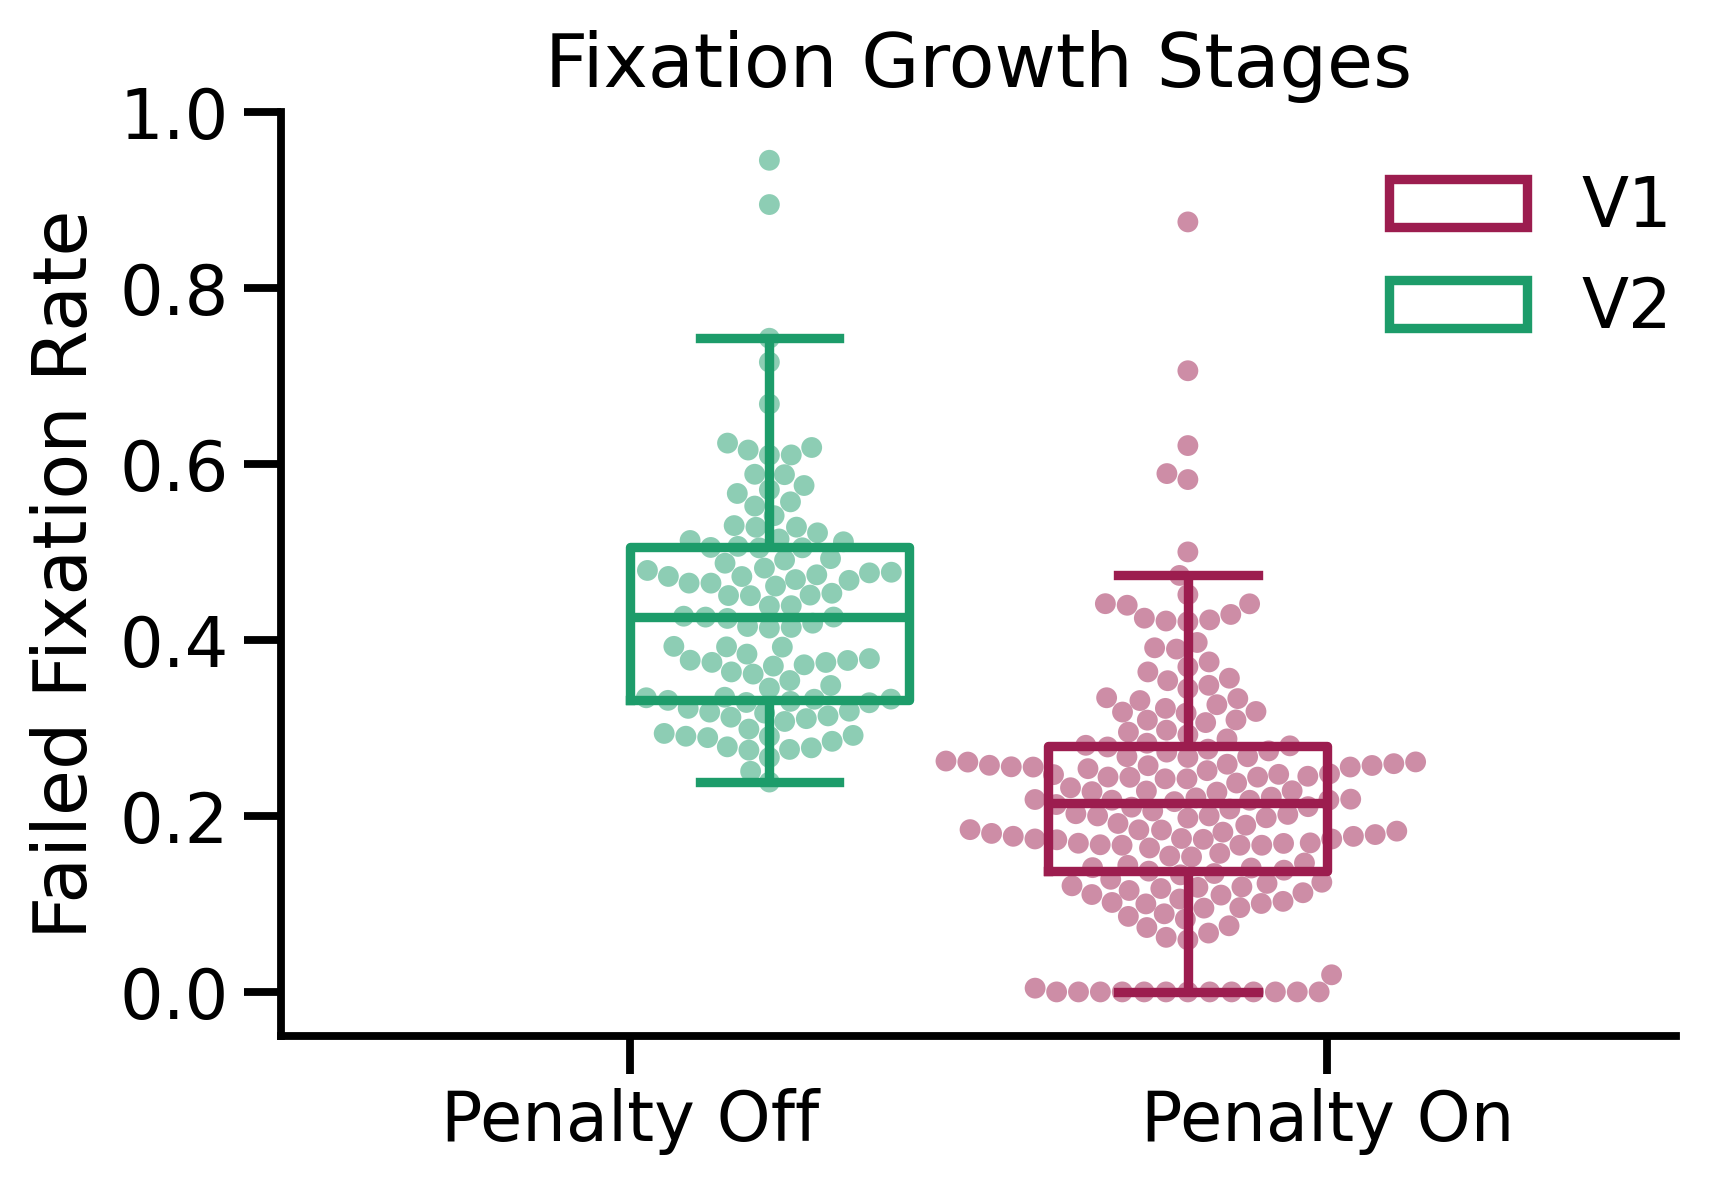

In [184]:
fig, ax = pu.make_fig("m")
sns.despine()

sns.boxplot(
    data=cpoke_learning_failed_fix.query("stage < 8"),
    x="type",
    order=["Penalty Off", "Penalty On"],
    y="failure_rate",
    hue="fix_experiment",
    hue_order=["V1", "V2"],
    palette=pu.ALPHA_PALLETTE,
    ax=ax,
    fill=None,
    showfliers=False,
    dodge=True,
)
sns.swarmplot(
    data=cpoke_learning_failed_fix.query("stage < 8"),
    x="type",
    order=["Penalty Off", "Penalty On"],
    y="failure_rate",
    hue="fix_experiment",
    hue_order=["V1", "V2"],
    palette=pu.ALPHA_PALLETTE,
    ax=ax,
    dodge=True,
    legend=False,
    alpha=0.5,
)
_ = ax.set(
    xlabel="",
    ylabel="Failed Fixation Rate",
    title="Fixation Growth Stages",
    ylim=(-0.05, 1),
)

ax.legend(title=None, bbox_to_anchor=(0.75, 1), frameon=False)

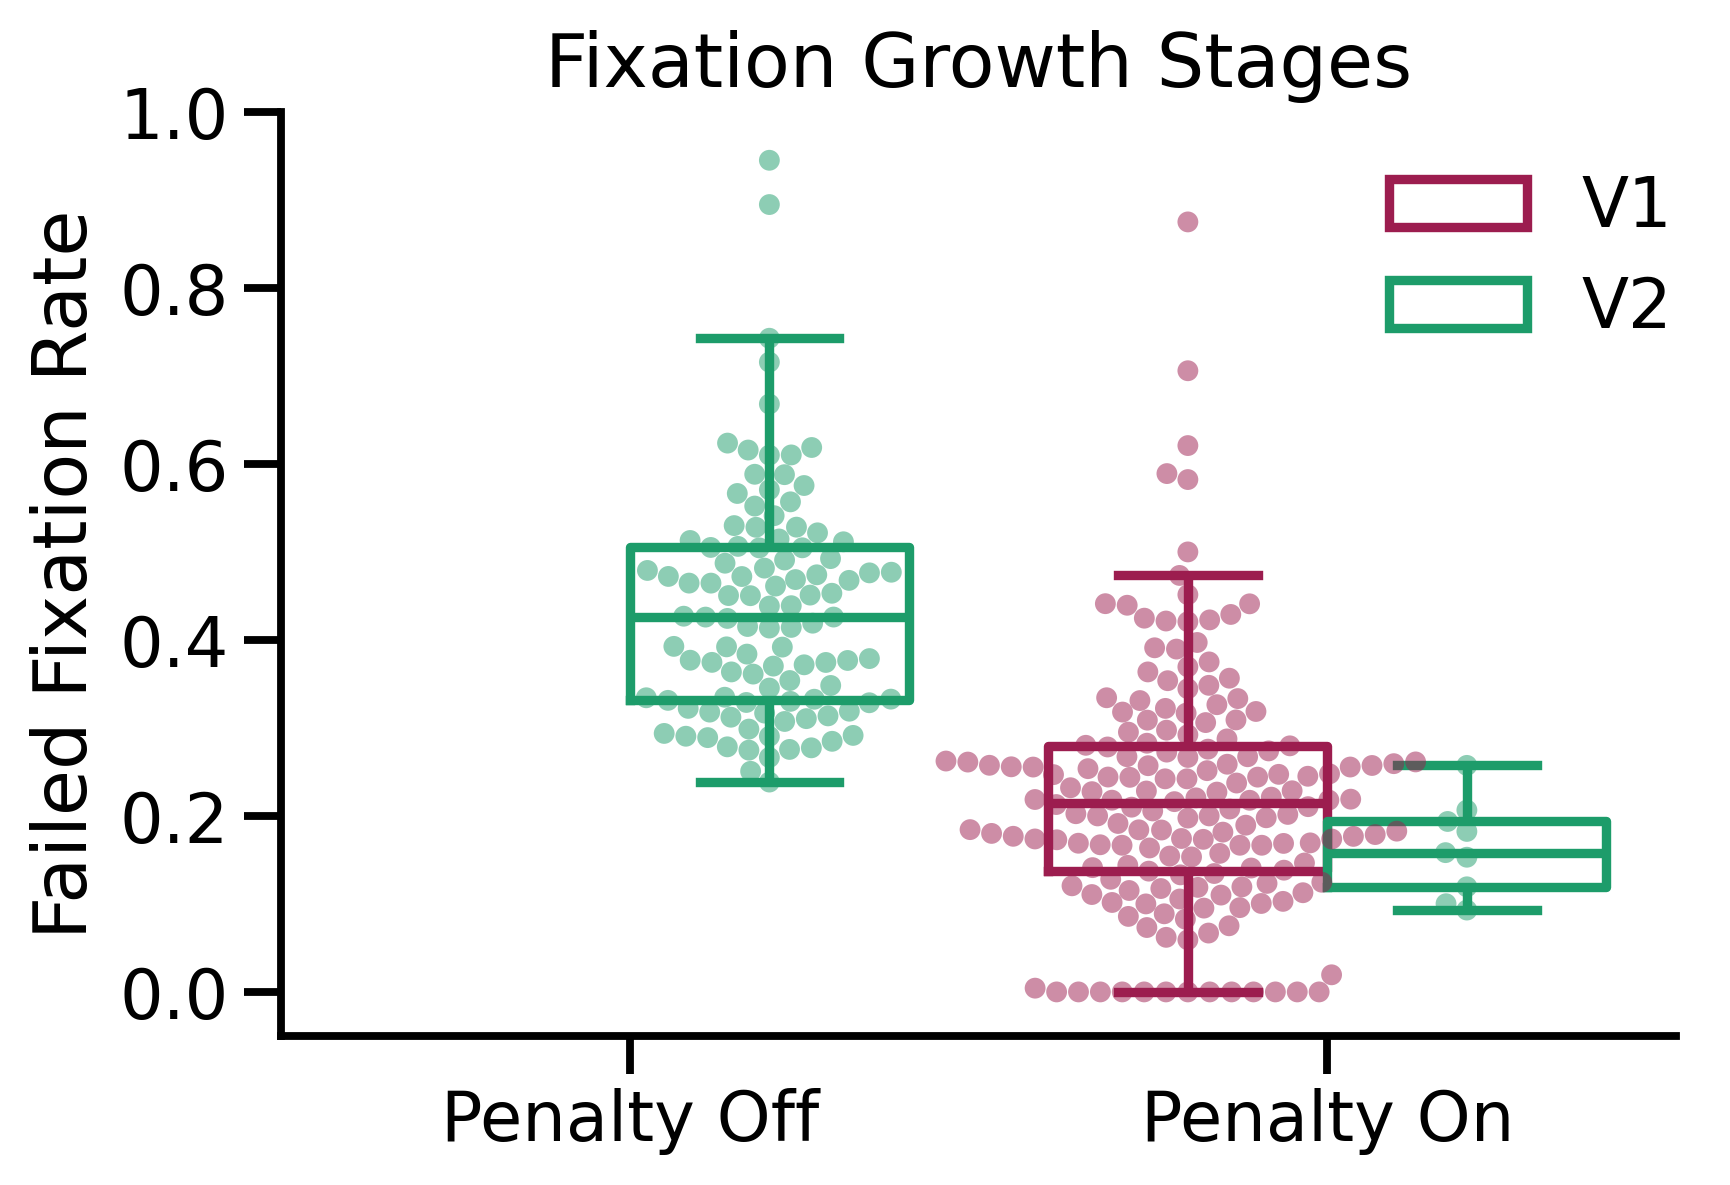

In [183]:
fig, ax = pu.make_fig("m")
sns.despine()

sns.boxplot(
    data=cpoke_learning_failed_fix,
    x="type",
    order=["Penalty Off", "Penalty On"],
    y="failure_rate",
    hue="fix_experiment",
    hue_order=["V1", "V2"],
    palette=pu.ALPHA_PALLETTE,
    ax=ax,
    fill=None,
    showfliers=False,
    dodge=True,
)
sns.swarmplot(
    data=cpoke_learning_failed_fix,
    x="type",
    order=["Penalty Off", "Penalty On"],
    y="failure_rate",
    hue="fix_experiment",
    hue_order=["V1", "V2"],
    palette=pu.ALPHA_PALLETTE,
    ax=ax,
    dodge=True,
    legend=False,
    alpha=0.5,
)
_ = ax.set(
    xlabel="",
    ylabel="Failed Fixation Rate",
    title="Fixation Growth Stages",
    ylim=(-0.05, 1),
)

ax.legend(title=None, bbox_to_anchor=(0.75, 1), frameon=False)

### 3.1.2 Stage 7 -> 8 Transition

In [138]:
v2_penalty_on_df = failed_fix_df.query("fix_experiment == 'V2'").copy()
v2_penalty_on_df = viz.df_preperation.compute_days_relative_to_stage(
    failed_fix_df, 8
).reset_index()

[Text(0, 0.5, 'Fixation Failure Rate'),
 Text(0.5, 0, 'Days Relative to Penalty On'),
 (0.0, 1.0)]

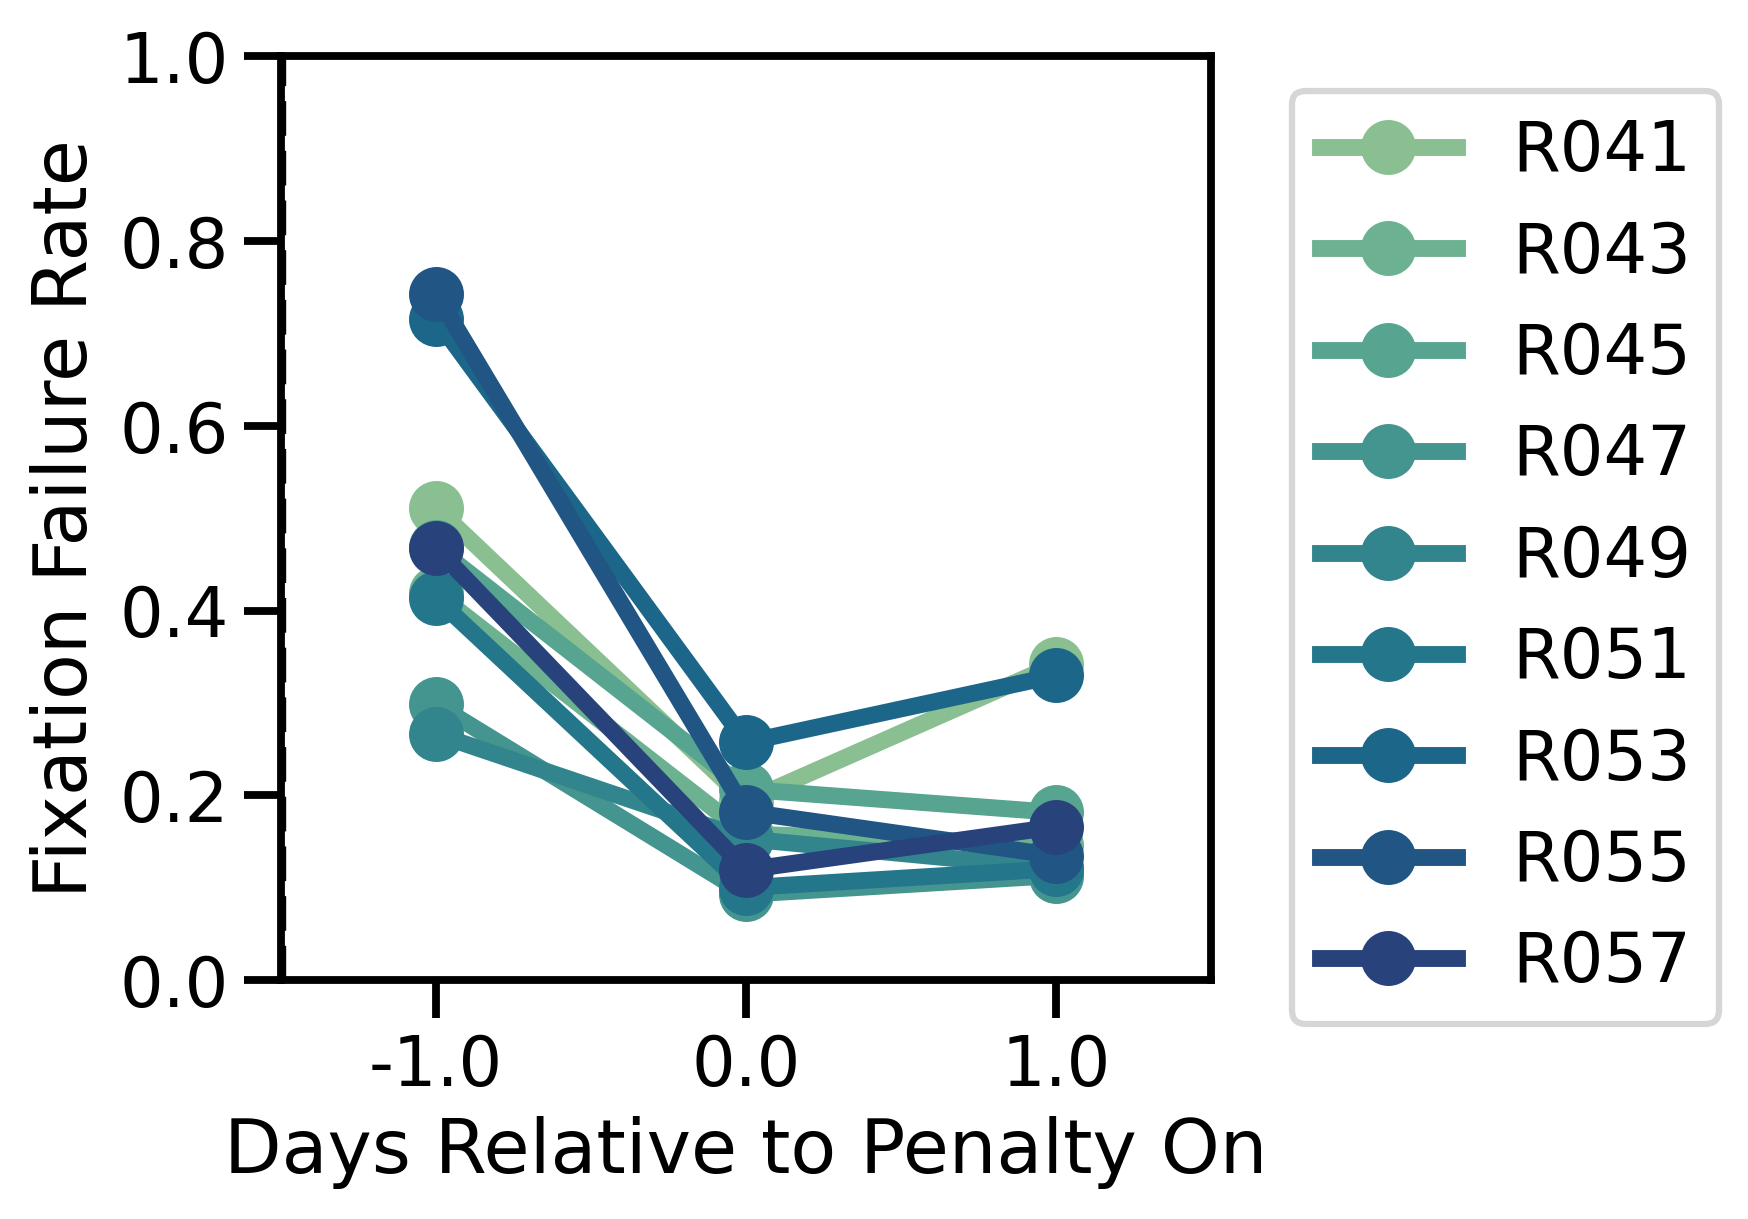

In [150]:
fig, ax = pu.make_fig("s")
day_range = [-1, 1]

plot_df = v2_penalty_on_df.query(
    "days_relative_to_stage_8 >= @day_range[0] and days_relative_to_stage_8 <= @day_range[1]"
)
sns.pointplot(
    data=plot_df,
    x="days_relative_to_stage_8",
    y="failure_rate",
    hue="animal_id",
    palette=pu.ALPHA_V2_palette,
    ax=ax,
)
ax.axvline(-0.5, color="black", linestyle="--")
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

ax.set(
    ylabel="Fixation Failure Rate", xlabel="Days Relative to Penalty On", ylim=(0, 1)
)

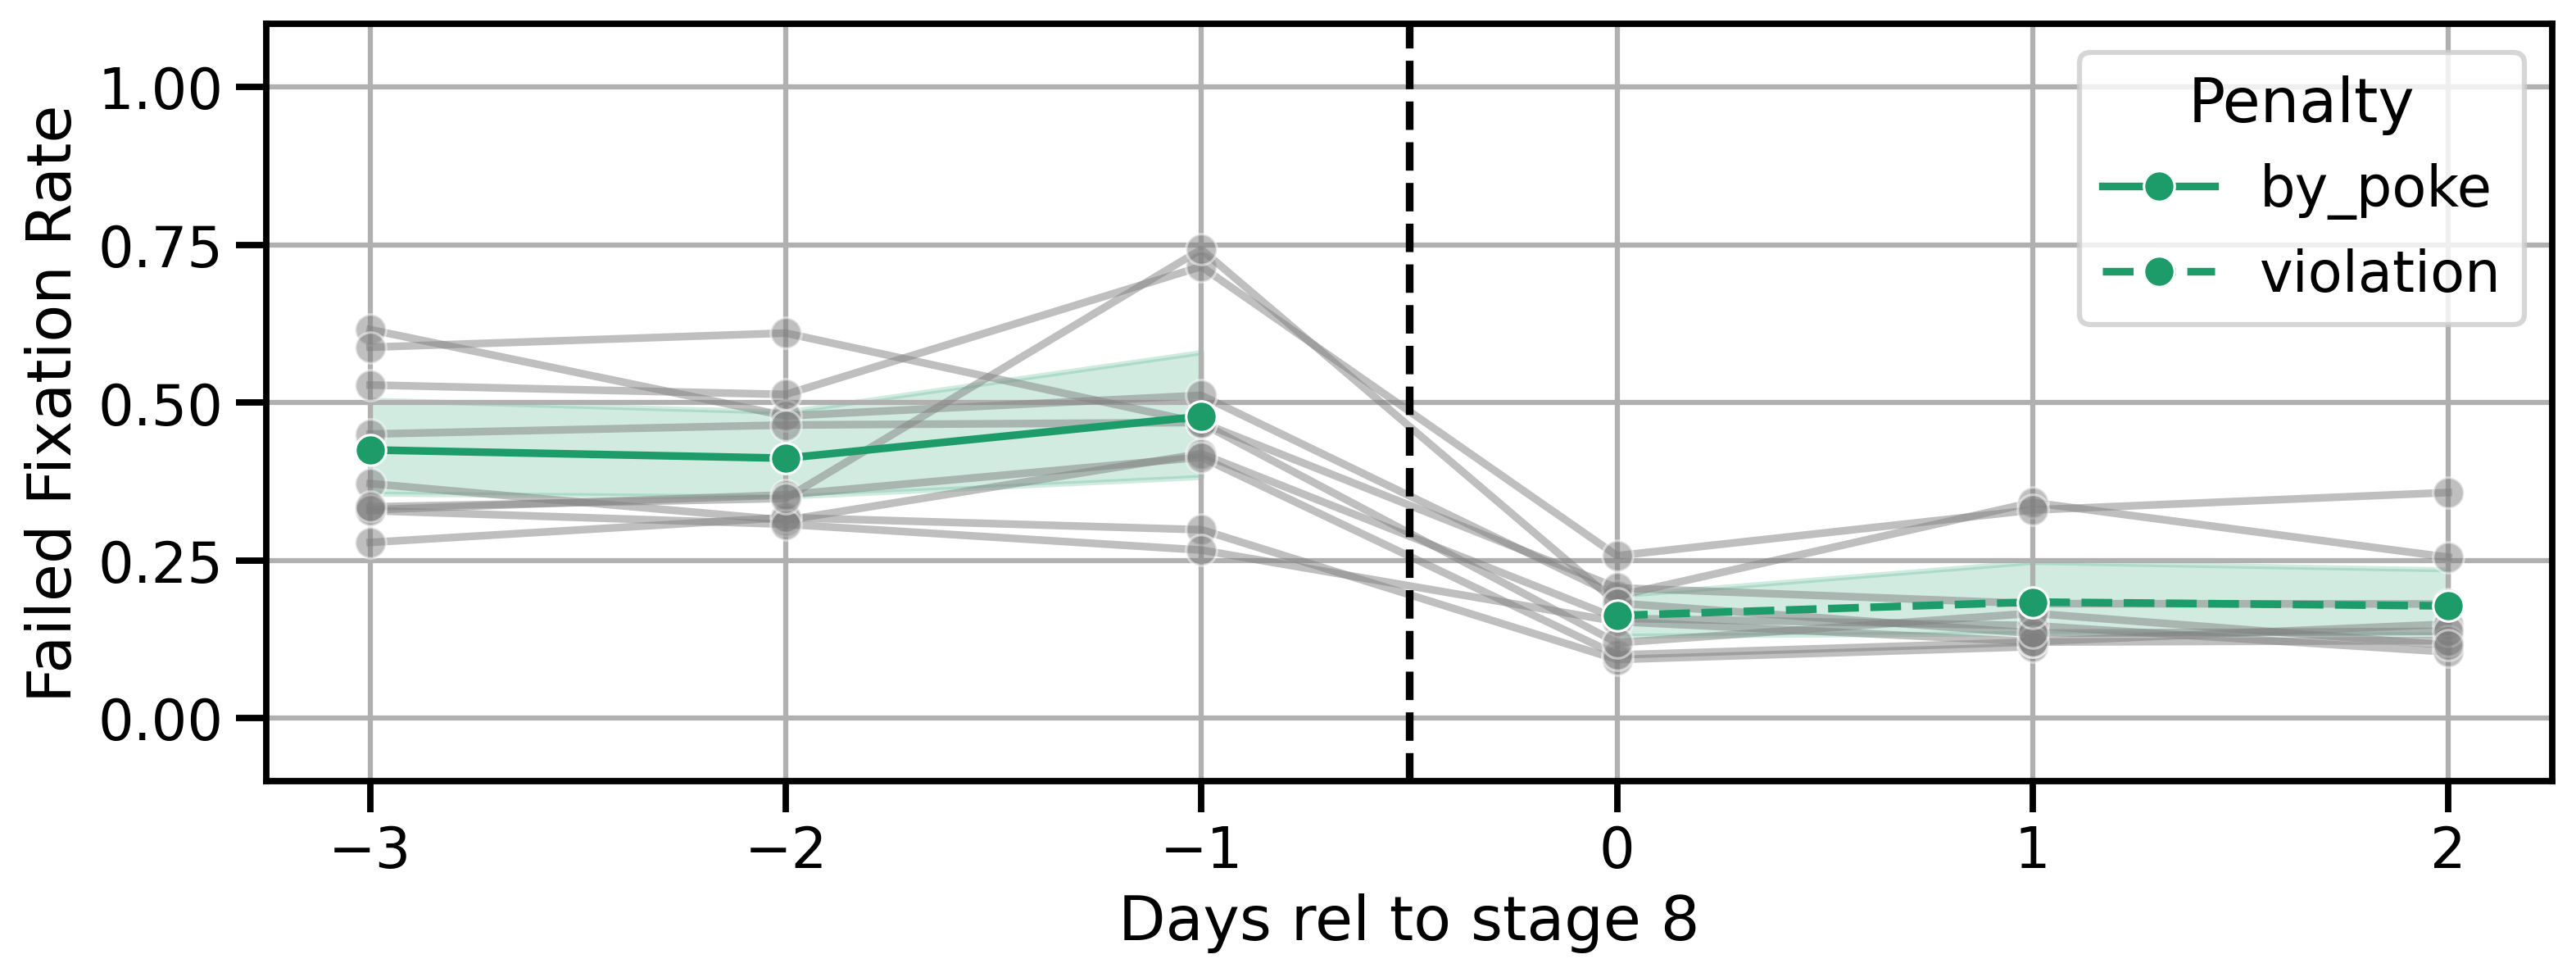

In [159]:
fig, ax = pu.make_fig()
viz.FixationGrower.exp_compare_alpha.plot_failed_fixation_rate_turn_penalty_on(
    tdf, max_stage=9, day_range=(-3, 2), style="type", ax=ax
)

ax.legend(title="Penalty")

### 3.1.3 Probe Stage Violation Rates

#### Boxplots

/var/folders/__/8jn6qz211155h1xb451s5zcr0000gn/T/ipykernel_20527/2809383378.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Stable\nDelay", "Random\nDelay"])


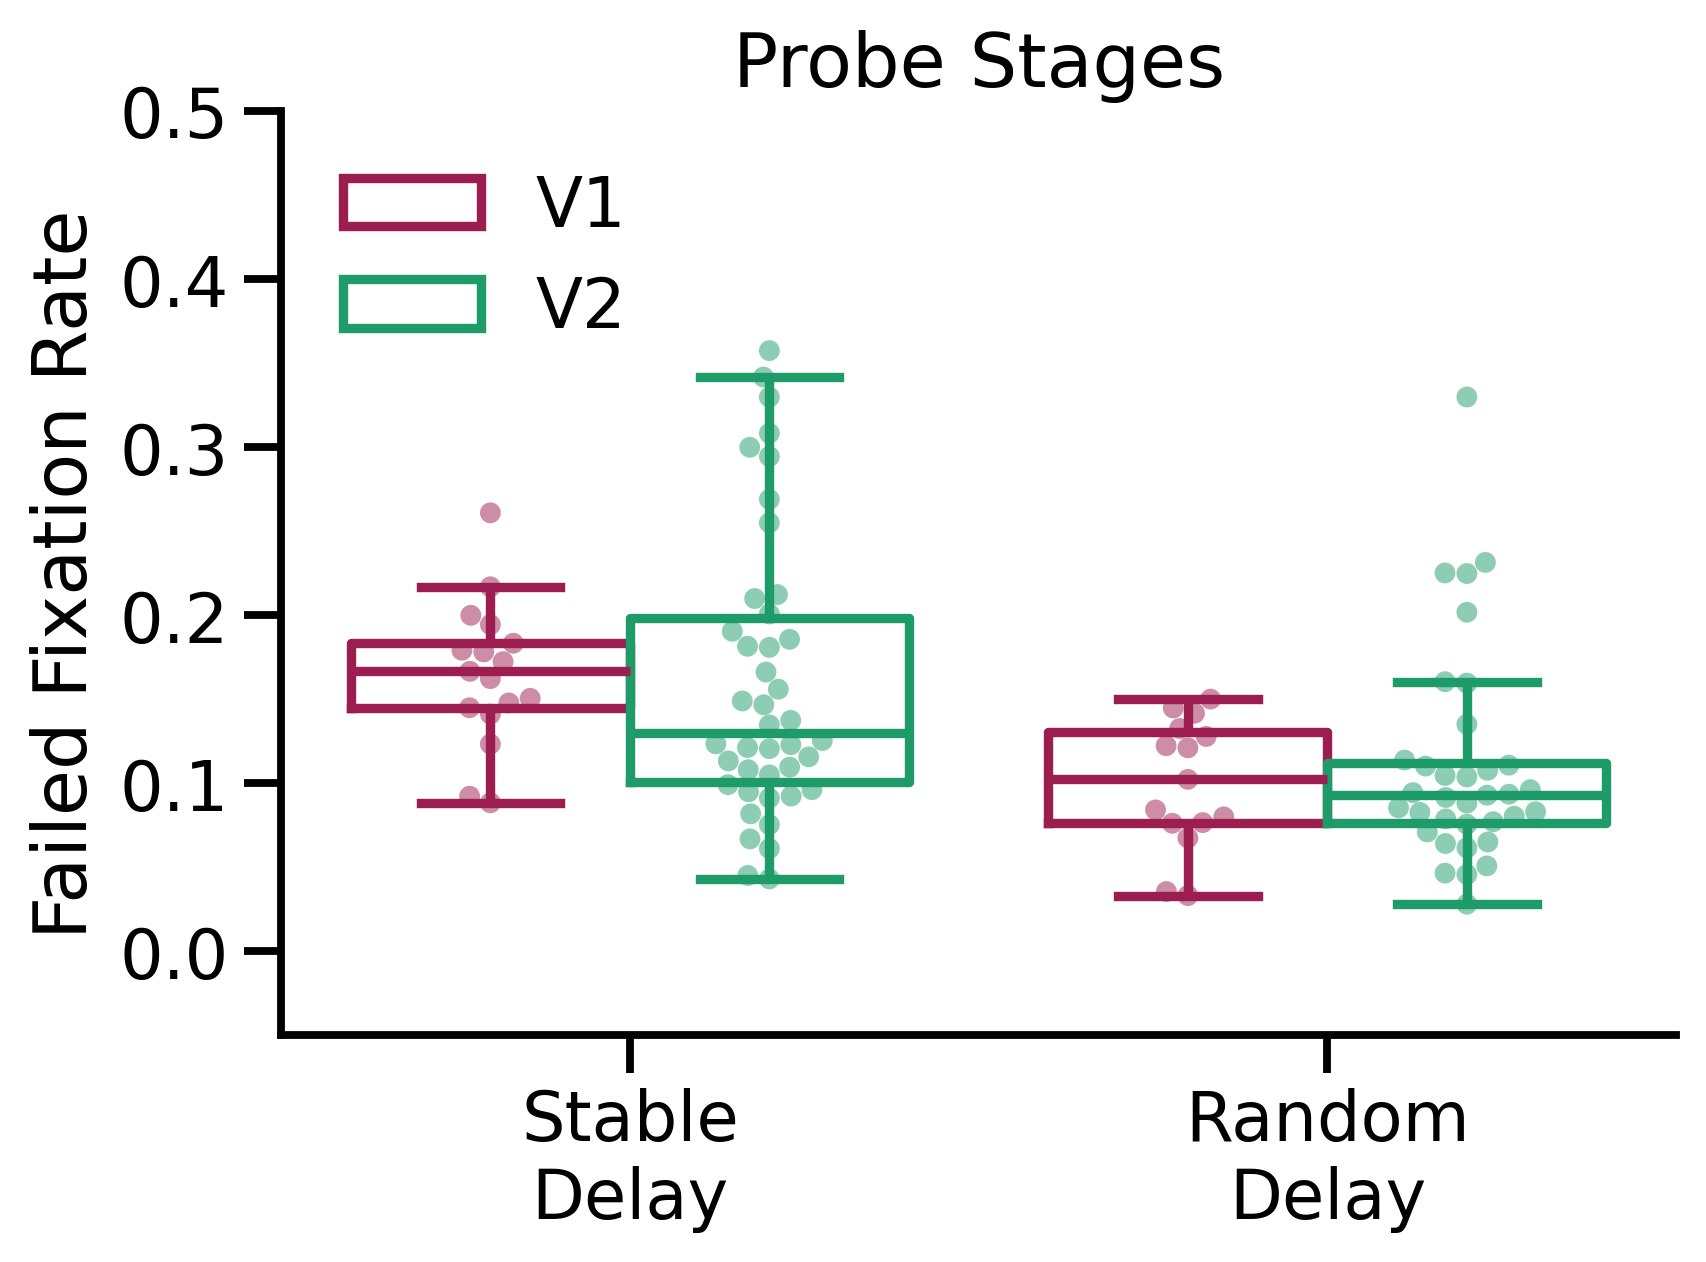

In [191]:
fig, ax = pu.make_fig("m")
sns.despine()

sns.boxplot(
    data=probe_failed_fix,
    x="stage",
    y="failure_rate",
    hue="fix_experiment",
    palette=pu.ALPHA_PALLETTE,
    ax=ax,
    fill=None,
    showfliers=False,
)

sns.swarmplot(
    data=probe_failed_fix,
    x="stage",
    y="failure_rate",
    hue="fix_experiment",
    palette=pu.ALPHA_PALLETTE,
    ax=ax,
    dodge=True,
    legend=False,
    alpha=0.5,
)

_ = ax.set(
    xlabel="",
    ylabel="Failed Fixation Rate",
    title="Probe Stages",
    ylim=(-0.05, 0.5),
)

ax.set_xticklabels(["Stable\nDelay", "Random\nDelay"])

ax.legend(title=None, frameon=False, loc="upper left")

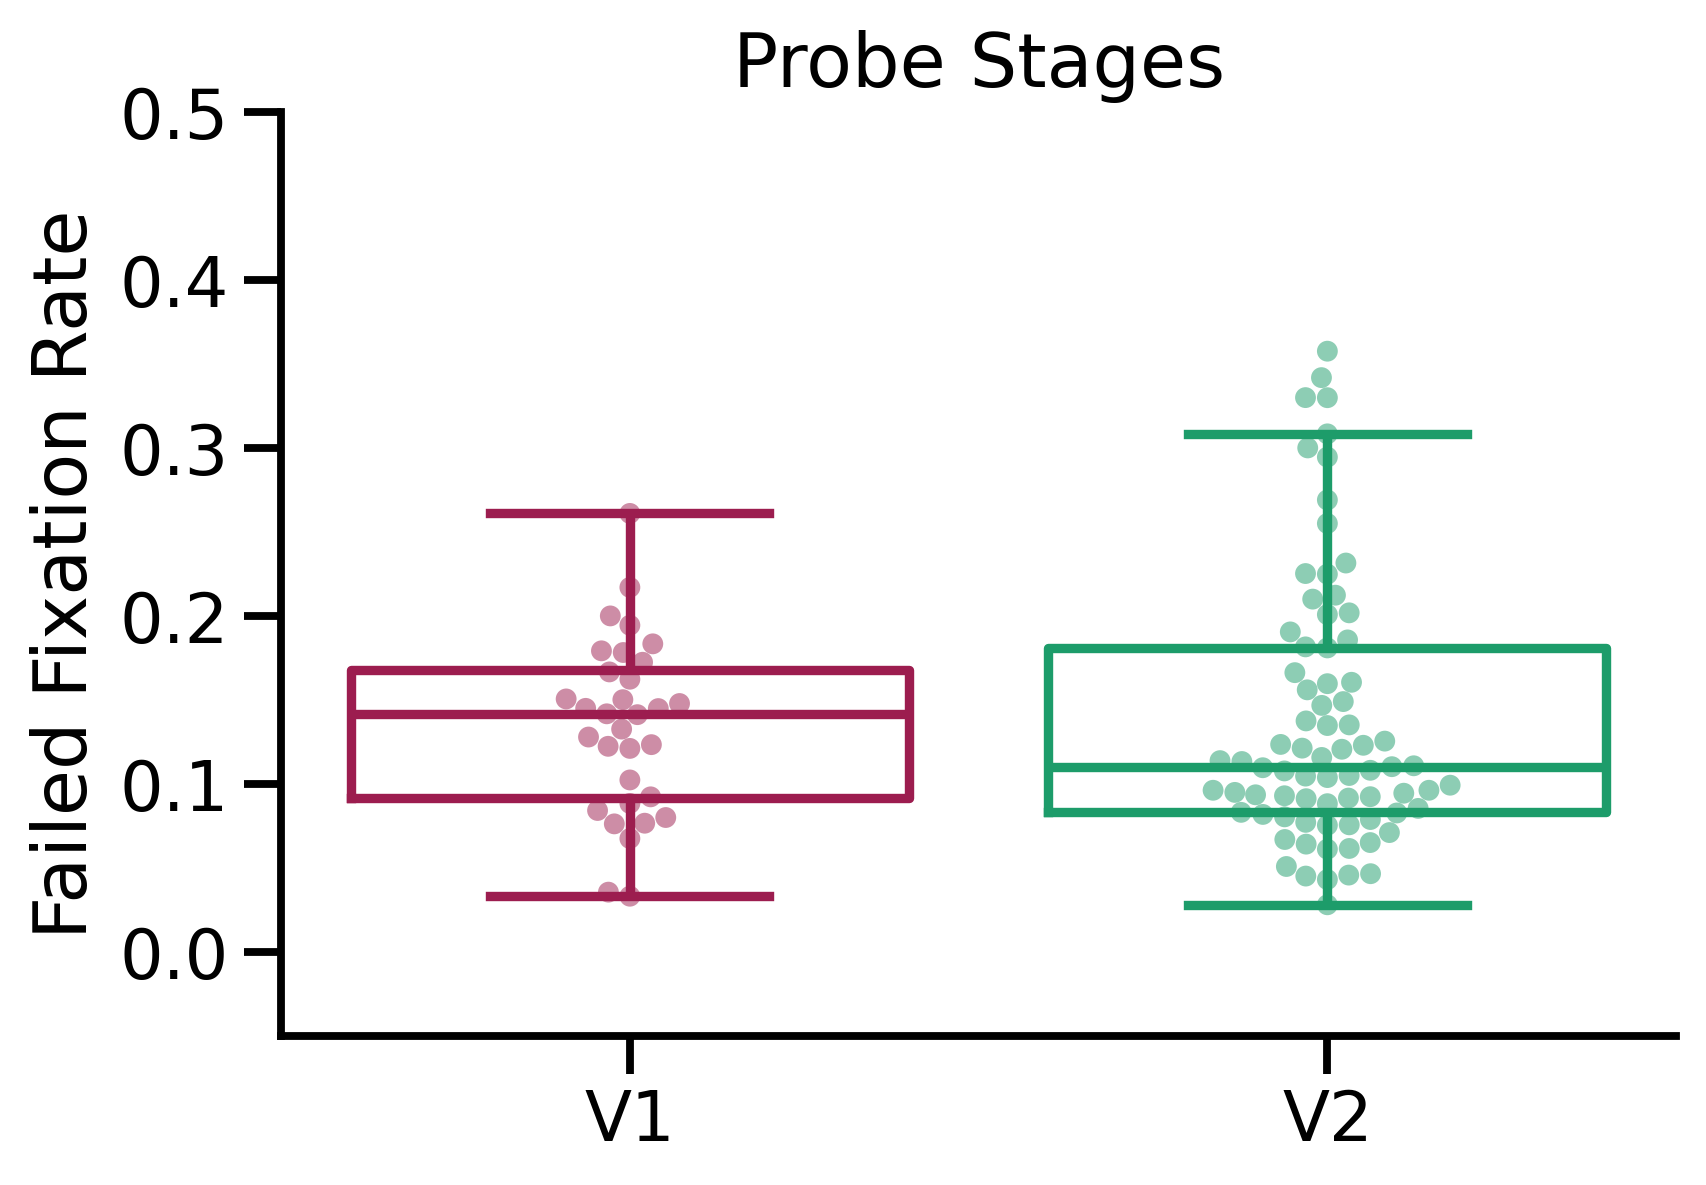

In [194]:
fig, ax = pu.make_fig("m")
sns.despine()

sns.boxplot(
    data=probe_failed_fix,
    x="fix_experiment",
    y="failure_rate",
    hue="fix_experiment",
    palette=pu.ALPHA_PALLETTE,
    ax=ax,
    fill=None,
    showfliers=False,
)

sns.swarmplot(
    data=probe_failed_fix,
    x="fix_experiment",
    y="failure_rate",
    hue="fix_experiment",
    palette=pu.ALPHA_PALLETTE,
    ax=ax,
    legend=False,
    alpha=0.5,
)

_ = ax.set(
    xlabel="",
    ylabel="Failed Fixation Rate",
    title="Probe Stages",
    ylim=(-0.05, 0.5),
)

### Point Plot

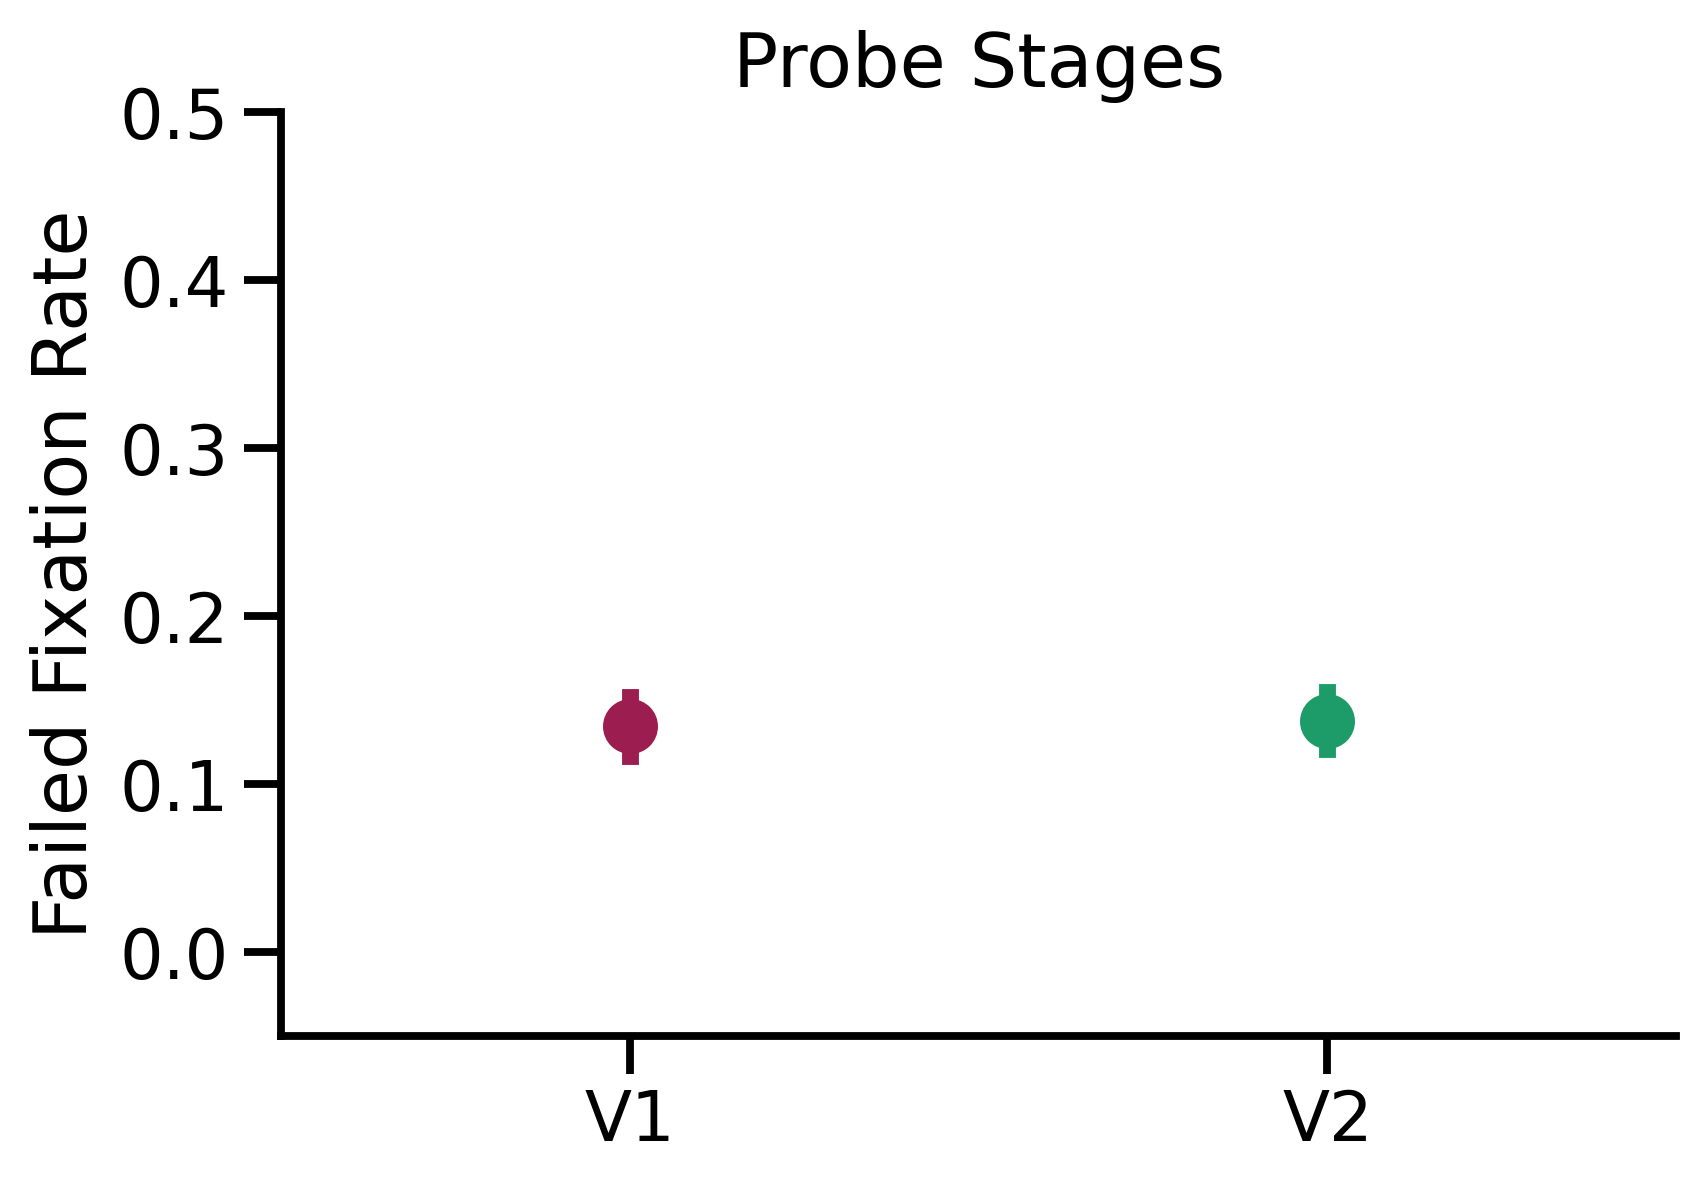

In [197]:
fig, ax = pu.make_fig("m")
sns.despine()

sns.pointplot(
    data=probe_failed_fix,
    x="fix_experiment",
    y="failure_rate",
    hue="fix_experiment",
    palette=pu.ALPHA_PALLETTE,
    ax=ax,
)


_ = ax.set(
    xlabel="",
    ylabel="Failed Fixation Rate",
    title="Probe Stages",
    ylim=(-0.05, 0.5),
)

#### Histograms

#### Over Days